In [1]:
from scipy.integrate import quad
from sympy import init_printing, latex
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
init_printing(latex_printer=lambda *args, **kwargs: latex(*args, mul_symbol='dot', **kwargs))

### Symbolic Solve

Assumptions:
    M_exp(t) = a*t^2+b*t+c
    M_exp(t) is quadratic to time t.   
    https://www.sciencedirect.com/topics/engineering/fluorescence-intensity

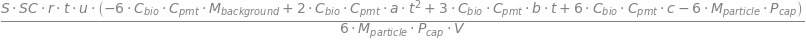

In [7]:
### Symbolic Solve:

# Set Symbols
t = smp.symbols('t', real=True, positive=True)
S, V, SC, r, P_cap, S_cap, u, \
    C_bio, C_pmt, M_background, M_particle,  = smp.symbols('S V SC r P_cap S_cap u C_bio C_pmt M_background M_particle', real=True, positive=True)

# Define Function F
# Assumption for M_exp_t
a,b,c = smp.symbols('a b c', real=True)
M_exp_t = a*t**2 + b*t + c
P_assoc= C_bio*C_pmt*(M_exp_t-M_background)/M_particle
F_cell = SC*r*((P_cap-P_assoc)/P_cap)*u
F = -S/V*F_cell

## Solve the function
smp.integrate(F, t).simplify()


### Numerical Solve

In [17]:
## Define Equation like this:
def integrand(x, a, b):
    return a*x**2 + b

# Define Function Arguments
args=(2,1)
## Define Upper and Lower bound
boundary = [0, +np.inf]

## Solve
result = quad(integrand, boundary[0], boundary[1], args=args)
print("Solution:", result[0])
print("Error:", result[1])

Solution: -1.6668007527776414
Error: 0.00025628032154401126


/tmp/ipykernel_7310/3112862291.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = quad(integrand, boundary[0], boundary[1], args=args)


## Example1 Simple Integral

### General Idea: Use Euler's Formula.
#### - Can use exact value of [derivative * stepSize]: (f(x+h)-f(x))/h = dy/dx   small steps get derivative
#### - Can also use [Integral]: (f(x+dx)-f(x))/dx = dy/dx   (dx Integration towards x, caveats)

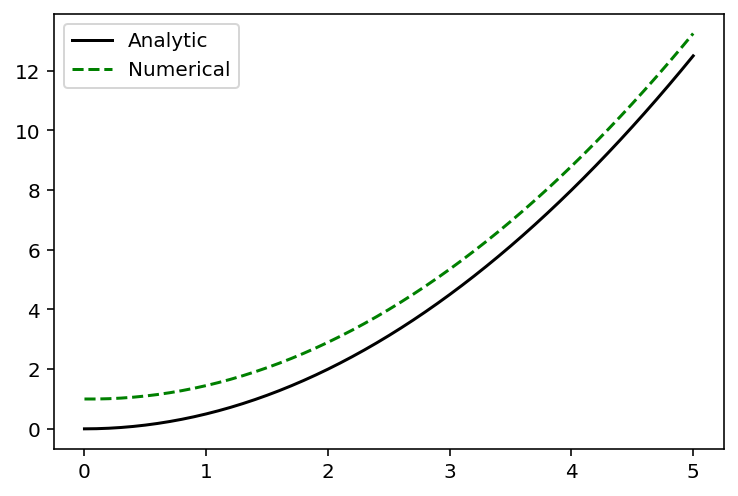

In [16]:
import numpy as np
import matplotlib.pyplot as plt


# define dy/dx = x
def dy(x):
    return x
    
h = 0.1 # step size

# integral boundary
a = 0
b = 5

# set up x according to step size
x = np.arange(a, b+h, h)
# store solution value based on initialised x
w = np.zeros(x.shape)

# get True analysis equation
y = 1/2*x**2

# initial value
w[0] = 1 
# Iteration to Solve
for i in range( len(x) - 1 ):
    w[i+1] = w[i] + h * x[i]
    #w[i+1] = w[i] + quad(dy, x[i], x[i+1])[0]
    
fig = plt.figure(dpi = 144)
ax = fig.gca()
ax.plot(x, y, 'k-', label="Analytic")
ax.plot(x, w, 'g--', label="Numerical")
ax.legend(loc="upper left")
# plt.savefig("./1.jpg")
plt.show()

## Example2: Differential Equation

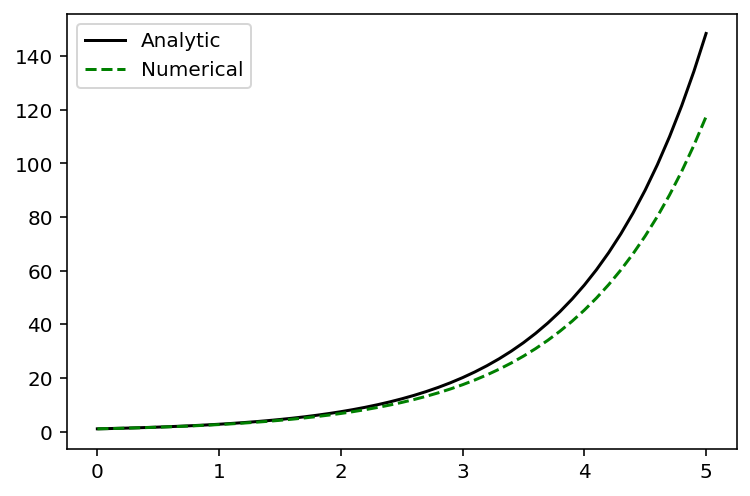

In [159]:
import numpy as np
import matplotlib.pyplot as plt


# define dy/dx = y  # important: y not x here
def dy(y):
    return y 

# define dy/dx = y  # important: y not x here
def dy2(x, y):
    return y 
    
h = 0.1 # step size

# integral boundary
a = 0
b = 5

# set up x according to step size
x = np.arange(a, b+h, h)
# store solution value based on initialised x
w = np.zeros(x.shape)

# get True analysis equation
y = np.exp(x)

# initial value
w[0] = 1 
# Iteration to Solve
for i in range( len(x) - 1 ):
    y = w[i]
    #w[i+1] = w[i] + h * dy(w[i])  ## Normal Euler
    w[i+1] = w[i] + quad(dy2, x[i], x[i+1], args=w[i])[0]   # Integral regarding X, (NOT Y)
    #w[i+1] = w[i] + (h/2) * (dy(w[i]) + dy(w[i] + h * dy(w[i])))  ## Advanced Euler
    
fig = plt.figure(dpi = 144)
ax = fig.gca()
ax.plot(x, y, 'k-', label="Analytic")
ax.plot(x, w, 'g--', label="Numerical")
ax.legend(loc="upper left")
# plt.savefig("./1.jpg")
plt.show()

## SOLVE

In [4]:


class ODE_Concentration:
    """Solve ODE using numerical iterations"""
    def __init__(self, STEP_SIZE, TARGET_TIME, INIT_U, INIT_P, params):
        self.STEP_SIZE = STEP_SIZE
        self.TARGET_TIME = TARGET_TIME
        self.INIT_U = INIT_U
        self.INIT_P = INIT_P
        self.params = params
        self.solve()

    ## Define Functions
    def f_cell_CCC(self, SC, r, P_capacity, p, u):
        return SC * r * (P_capacity-p)/P_capacity*u

    def du(self, S,V,f_cell):
        return -(S/V) * f_cell

    def dp(self, S,V,f_cell):
        return +(S/V) * f_cell

    def solve(self):
        ## Assign Values
        h = self.STEP_SIZE
        t = np.arange(0, self.TARGET_TIME+h, h)
        u = np.zeros(t.shape)
        p = np.zeros(t.shape)
        adv_u = np.zeros(t.shape)
        adv_p = np.zeros(t.shape)
        u[0] = self.INIT_U
        p[0] = self.INIT_P
        adv_u[0] = self.INIT_U
        adv_p[0] = self.INIT_P
        SC = self.params["SC"][1]
        r = self.params["r"][1]
        P_capacity = self.params["P_capacity"][1]
        S = self.params["S"][1]
        V = self.params["V"][1]

        ## Iterate and update
        for i in range( len(t) - 1 ):
            ## Normal Euler Method:  predict [NEXT point] using [CURRENT derivative]
            # Update U
            u[i+1] = u[i] + h * self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, p[i], u[i]))
            # Update P
            p[i+1] = p[i] + h * self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, p[i], u[i]))

            ## Advanced Euler Method: predict [NEXT point] using [CURRENT derrivarive]&[NEXT point's derivative]
            cur_du = self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i], adv_u[i]))
            cur_dp = self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i], adv_u[i]))

            pred_du = self.du(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i] + h * cur_dp, adv_u[i] + h * cur_du))
            pred_dp = self.dp(S,V, self.f_cell_CCC(SC,r,P_capacity, adv_p[i] + h * cur_dp, adv_u[i] + h * cur_du))

            adv_u[i+1] = adv_u[i] + (h/2) * (cur_du + pred_du)
            adv_p[i+1] = adv_p[i] + (h/2) * (cur_dp + pred_dp)
        self.adv_u = adv_u
        self.adv_p = adv_p
        self.p = p
        self.u = u
        self.t = t

    def get_params(self):
        print("{:<15} {:<30} {:<10}".format('Key','Label','Data'))
        for k, v in self.params.items():
            label, data = v
            print("{:<15} {:<30} {:<10}".format(k, label, data))

    ## Plotting
    def plot_integral(self):
        self.get_params()
        fig = plt.figure(dpi = 144)
        ax = fig.gca()
        ax.plot(self.t, self.u, 'r-', label="euler In Fluid")
        ax.plot(self.t, self.p, 'b-', label="euler In Particles")
        ax.plot(self.t, self.adv_u, 'r--', label="adv_euler In Fluid")
        ax.plot(self.t, self.adv_p, 'b--', label="adv_euler In Particles")
        ax.set_ylabel("Concentration")
        ax.set_xlabel("Time")
        ax.set_title("Concentration of Particles")
        ax.legend(loc='center right')
        # plt.savefig("./1.jpg")
        plt.show()
        

    def get_fluid_concentration(self):
        return self.adv_u[-1]

    def get_cell_concentration(self):
        return self.adv_p[-1]


Key             Label                          Data      
SC              Surface Coverage               1         
r               Rate of Association            2         
P_capacity      Cell Capacity                  3         
S               Surface Area                   2         
V               Volume                         1         


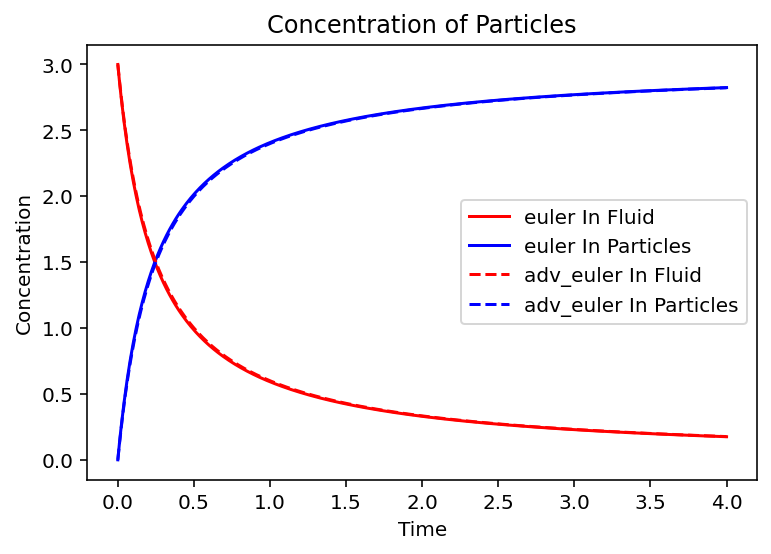

Cell Concentration p : 2.82352143019305


In [10]:
## Define Values
STEP_SIZE = 0.01
TARGET_TIME = 4
INIT_U = 3
INIT_P = 0
params = {   # Symbol + Description + Data
            "SC":["Surface Coverage", 1],
            "r":["Rate of Association", 2],
            "P_capacity":["Cell Capacity", 3],
            "S":["Surface Area", 2],
            "V":["Volume", 1],
        }

ode = ODE_Concentration(STEP_SIZE, TARGET_TIME, INIT_U, INIT_P, params)
ode.plot_integral()
print("Cell Concentration p :", ode.get_cell_concentration())